In [1]:
import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import List, Sequence, Tuple
from sklearn.preprocessing import StandardScaler

import importlib
import stockanalibs
importlib.reload(stockanalibs)

pd.set_option('display.max_columns', None)


In [2]:
ticker = stockanalibs.ticker
folder = "Intraday stocks" 

bidasktoclose_spread = 0.03

date_to_check = None
date_to_check = '2020-02' # if 'None' (just comment this line) all dates to be analyzed and final merged CSV to be saved

dfs training/GOOGL_base.csv already exists. Reading and plotting the processed data...


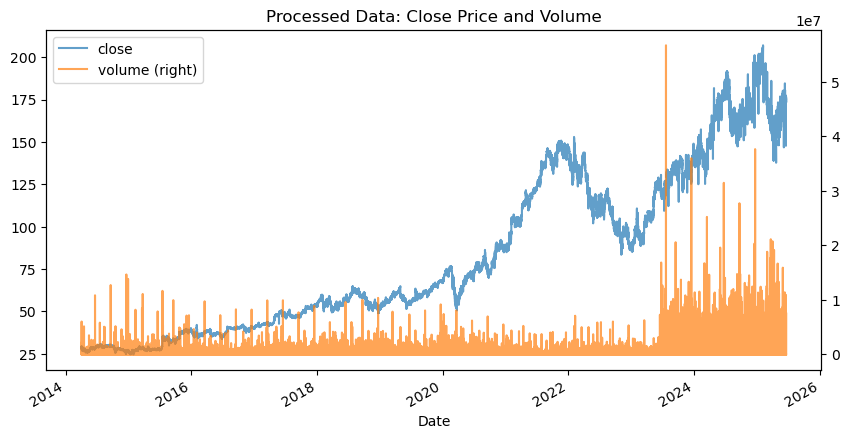

open      high       low     close   volume  \
datetime                                                               
2014-04-03 10:42:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 10:43:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 11:04:00   28.6500   28.6500   28.6500   28.6500  11220.0   
2014-04-03 11:05:00   28.6500   28.6500   28.6500   28.6500   4620.0   
2014-04-03 11:34:00   28.5005   28.5005   28.5005   28.5005   3460.0   
...                       ...       ...       ...       ...      ...   
2025-06-18 23:55:00  173.9000  173.9445  173.8670  173.8681   3136.0   
2025-06-18 23:56:00  173.8200  173.9500  173.7900  173.9000    183.0   
2025-06-18 23:57:00  173.9500  173.9500  173.8600  173.8601    240.0   
2025-06-18 23:58:00  173.8600  173.9000  173.8600  173.8600    327.0   
2025-06-18 23:59:00  173.8700  173.8700  173.8600  173.8700    124.0   

                            ask         bid  
datetime                                     
2014-04-03 10:42:00   28.658595   28.641405  
2014-04-03 10:43:00   28.658595   28.641405  
2014-04-03 11:04:00   28.658595   28.641405  
2014-04-03 11:05:00   28.658595   28.641405  
2014-04-03 11:34:00   28.509050   28.491950  
...                         ...         ...  
2025-06-18 23:55:00  173.920300  173.815900  
2025-06-18 23:56:00  173.952200  173.847800  
2025-06-18 23:57:00  173.912300  173.807900  
2025-06-18 23:58:00  173.912200  173.807800  
2025-06-18 23:59:00  173.922200  173.817800  

[1462494 rows x 7 columns]

In [3]:
# first process of the dataframe, adding artificial bid and ask prices, and correcting possible price splits

df = stockanalibs.process_splits(folder=folder, 
                                ticker=ticker, 
                                bidasktoclose_spread=bidasktoclose_spread,
                                vol_fact=1)
df

In [4]:
display(HTML("""
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
"""))


In [5]:
def plot_trades(df, trades, buy_threshold, performance_stats, trade_color="green"):
    """
    Plots the overall close-price series plus trade intervals and two continuous signals,
    with the signals shown on a secondary y-axis.

    • The base trace (grey) plots the close-price series on the primary y-axis.
    • Trade traces (green by default) indicate the intervals for each trade from the original trade list.
    • A dotted blue line shows the raw normalized "signal" on a secondary y-axis.
    • A dashed red line shows the smooth normalized signal on the secondary y-axis.
    • A horizontal dotted line is drawn at the buy_threshold.
    • Additionally, areas between each buy and sell event determined by the new 
      "trade_action" field (buy=+1, sell=-1) are highlighted (in orange).
    • An update menu is added with two buttons:
         - "Hide Trades": Hides only the trade-specific traces.
         - "Show Trades": Makes all traces visible.

    Parameters:
      df : pd.DataFrame
          DataFrame with a datetime index and at least the columns "close", "signal_norm",
          "signal_smooth_adjusted", and "trade_action".
      trades : list
          A list of tuples, each in the form:
            ((buy_date, sell_date), (buy_price, sell_price), profit_pc).
      buy_threshold : float
          The threshold used for candidate buy detection (shown as a horizontal dotted line on the 
          secondary y-axis).
      performance_stats : dict, optional
          Dictionary containing performance metrics. If provided and if it contains keys
          "Trade Gains ($)" and "Trade Gains (%)" (each a list), they will be added to the
          trade annotations. 
      trade_color : str, optional
          The color to use for the original trade traces.
    """
    fig = go.Figure()
    
    # Trace 0: Base close-price trace.
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['close'],
        mode='lines',
        line=dict(color='grey', width=1),
        name='Close Price',
        hoverinfo='x+y',
        hovertemplate="Date: %{x}<br>Close: %{y:.2f}<extra></extra>",
    ))
    
    # Trade traces: one per original trade.
    for i, trade in enumerate(trades):
        # Unpack the trade tuple: ((buy_date, sell_date), (buy_price, sell_price), profit_pc)
        (buy_date, sell_date), (_, _), trade_return = trade
        trade_df = df.loc[buy_date:sell_date]
        fig.add_trace(go.Scatter(
            x=trade_df.index,
            y=trade_df['close'],
            mode='lines+markers',
            line=dict(color=trade_color, width=3),
            marker=dict(size=4, color=trade_color),
            name=f"Trade {i+1}",
            hoveron='points',
            hovertemplate=f"Trade {i+1}: Return: {trade_return:.2f}%<extra></extra>",
            visible=True
        ))
        
    # --------------------------------------------------------------------
    # New Trade Action Highlights: using the 'trade_action' field.
    # Extract rows where trade_action is not zero.
    trade_events = df[df["trade_action"] != 0]["trade_action"]
    pairs = []
    prev_buy = None
    for timestamp, action in trade_events.items():
        if action == 1:   # Buy signal
            prev_buy = timestamp
        elif action == -1 and prev_buy is not None:
            pairs.append((prev_buy, timestamp))
            prev_buy = None
    # For each buy-sell pair, add a vertical shaded region with annotation.
    for j, (buy_ts, sell_ts) in enumerate(pairs):
        if (performance_stats is not None and 
            "Trade Gains ($)" in performance_stats and 
            "Trade Gains (%)" in performance_stats and 
            len(performance_stats["Trade Gains ($)"]) > j and 
            len(performance_stats["Trade Gains (%)"]) > j):
            ann_text = (f"TA Trade {j+1}<br>$: {performance_stats['Trade Gains ($)'][j]}<br>"
                        f"%: {performance_stats['Trade Gains (%)'][j]}")
        else:
            ann_text = f"TA Trade {j+1}"
            
        fig.add_vrect(
            x0=buy_ts, x1=sell_ts,
            fillcolor="orange", opacity=0.25,
            line_width=0,
            annotation_text=ann_text,
            annotation_position="top left",
            annotation_font_color="orange"
        )
    # --------------------------------------------------------------------
    
    # Raw Signal trace: Plot the normalized "signal" on a secondary y-axis.
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['signal_norm'],
        mode='lines',
        line=dict(color='blue', width=2, dash='dot'),
        name='Signal (Normalized)',
        hovertemplate="Date: %{x}<br>Signal: %{y:.2f}<extra></extra>",
        visible=True,
        yaxis="y2"
    ))
    
    # Smooth Signal trace: Plot the smooth normalized signal on a secondary y-axis.
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['signal_smooth_adjusted'],
        mode='lines',
        line=dict(color='red', width=2, dash='dash'),
        name='Smooth Signal (Normalized)',
        hovertemplate="Date: %{x}<br>Smooth Signal: %{y:.2f}<extra></extra>",
        visible=True,
        yaxis="y2"
    ))
    
    # Add a horizontal dotted line for the buy_threshold (on secondary y-axis).
    fig.add_hline(y=buy_threshold, line=dict(color="purple", dash="dot"),
                  annotation_text="Buy Threshold", annotation_position="top left", yref="y2")
    
    # Total traces: 1 Base + n_trades (original trades) + 2 (for the signal traces).
    n_trades = len(trades)
    total_traces = 1 + n_trades + 2
    vis_show = [True] * total_traces  
    vis_hide = [True] + ["legendonly"] * n_trades + [True, True]
    
    fig.update_layout(
        updatemenus=[
            {
                "type": "buttons",
                "direction": "left",
                "buttons": [
                    {
                        "label": "Hide Trades",
                        "method": "update",
                        "args": [{"visible": vis_hide}],
                    },
                    {
                        "label": "Show Trades",
                        "method": "update",
                        "args": [{"visible": vis_show}],
                    },
                ],
                "pad": {"r": 10, "t": 10},
                "showactive": True,
                "x": 0.9,
                "xanchor": "left",
                "y": 1.1,
                "yanchor": "top",
            }
        ],
        hovermode="x unified",
        template="plotly_white",
        title="Close Price, Trade Intervals, and Signals",
        xaxis_title="Datetime",
        yaxis_title="Close Price",
        height=700,
        yaxis2=dict(
            title="Signal (Normalized)",
            overlaying="y",
            side="right",
            showgrid=False,
        )
    )
    
    fig.show()


In [6]:

def aggregate_performance(perf_list, round_digits=3):
    """
    Given a list of daily performance dictionaries, aggregate them as follows:
      - For numeric keys, sum their values and round the result.
      - For list keys (like "Trade Gains ($)" and "Trade Gains (%)"), replace them
        with a message indicating the number of trades.
    Then update:
      - "Strategy Profit Difference ($)" = "Final Net Value ($)" - "Buy & Hold Gain ($)"
      - "Strategy Improvement (%)"    = "Final Net Return (%)" - "Buy & Hold Return (%)"
    Returns the aggregated performance dictionary.
    """
    aggregated = {}
    keys = set()
    for perf in perf_list:
        if perf is not None:
            keys.update(perf.keys())
    for key in keys:
        if key in ["Trade Gains ($)", "Trade Gains (%)"]:
            temp_list = []
            for perf in perf_list:
                if perf and key in perf and isinstance(perf[key], list):
                    temp_list.extend(perf[key])
            aggregated[key] = f"{len(temp_list)} trades"
        else:
            total = 0
            for perf in perf_list:
                if perf and key in perf and isinstance(perf[key], (int, float)):
                    total += perf[key]
            aggregated[key] = round(total, round_digits)
    if "Final Net Value ($)" in aggregated and "Buy & Hold Gain ($)" in aggregated:
        aggregated["Strategy Profit Difference ($)"] = round(
            aggregated["Final Net Value ($)"] - aggregated["Buy & Hold Gain ($)"], round_digits)
    if "Final Net Return (%)" in aggregated and "Buy & Hold Return (%)" in aggregated:
        aggregated["Strategy Improvement (%)"] = round(
            aggregated["Final Net Return (%)"] - aggregated["Buy & Hold Return (%)"], round_digits)
    return aggregated

def saveDF_checkDAY(df, ticker, min_prof_thr, max_down_prop, gain_tightening_factor, 
                    smooth_win_sig, pre_entry_decay, buy_threshold, trailing_stop_thresh, 
                    merging_retracement_thr, merging_time_gap_thr, reference_gain,
                    keep_cols=["open", "high", "low", "close", "volume", "bid", "ask", 
                               "trade_action", "StrategyEarning", "EarningDiff", "signal_smooth_adjusted"], 
                    date_to_check=None):
    """
    Processes daily trading data for a given ticker.
    
    • If a full day (e.g. "2018-02-22") is provided, that day is processed as before.
    
    • If a month string (e.g. "2018-02") is provided, the function:
         – Determines all unique trading days (using df.index.normalize()) in that month.
         – For each trading day:
               * Executes Steps 1–4.
               * Prints the day's performance dictionary in a fixed order only once.
               * Displays the day's plot (which shows full trade details) non-blockingly, then closes it.
               * Appends the day's performance dictionary to a list (for aggregation).
         – After processing all days, aggregates the daily performance dictionaries so that:
               • Numeric values are summed & rounded.
               • "Strategy Profit Difference ($)" is calculated as (Final Net Value – Buy & Hold Gain).
               • "Strategy Improvement (%)" is calculated as (Final Net Return – Buy & Hold Return).
               • The raw trade lists are replaced by a message showing the total trade count.
         – Finally, prints the final monthly summary in a neatly formatted way.
    
    • If no date is provided, the function merges, cleans, and resamples the entire dataset.
         In this branch, extra print statements have been added for each sub-step.
    
    Note:
      – Smoothing is wrapped in try/except to catch errors like "min_periods 1 must be <= window 0."
      – When filtering for a specific day, the index is normalized (using only the date portion).
    """
    performance_list = []  # To collect daily performance dictionaries in month mode.
    
    def process_single_day(day_str):
        """Processes one trading day (given as a 'YYYY-MM-DD' string) and appends its performance."""
        print(f"\n=== Processing trading day {day_str} ===")
        day_dt = pd.to_datetime(day_str)
        # Filter the DataFrame to only the records for this day.
        day_df = df.loc[df.index.normalize() == day_dt].copy()
        if day_df.empty:
            print(f"No data found for {day_str}. Skipping.")
            return
        try:
            print(f"Step 1/5 for {day_str} => smooth_prepost_trading_data started at {datetime.now():%H:%M:%S}")
            try:
                day_df = stockanalibs.smooth_prepost_trading_data(
                    df=day_df,
                    regular_start=stockanalibs.regular_start,
                    regular_end=stockanalibs.regular_end,
                    red_pretr_win=stockanalibs.red_pretr_win)
            except ValueError as ve:
                if "min_periods" in str(ve) and "window 0" in str(ve):
                    print(f"Warning: smoothing failed for {day_str} (window=0). Using unsmoothed data.")
                else:
                    raise ve
            print(f"Step 1/5 for {day_str} => completed at {datetime.now():%H:%M:%S}")
            
            print(f"Step 2/5 for {day_str} => identify_trades_daily started at {datetime.now():%H:%M:%S}")
            results_by_day = stockanalibs.identify_trades_daily(
                df=day_df,
                min_prof_thr=min_prof_thr,
                max_down_prop=max_down_prop,
                gain_tightening_factor=gain_tightening_factor,
                regular_start_shifted=stockanalibs.regular_start_shifted,
                regular_end=stockanalibs.regular_end,
                merging_retracement_thr=merging_retracement_thr, 
                merging_time_gap_thr=merging_time_gap_thr,
                day_to_check=day_str)
            print(f"Step 2/5 for {day_str} => completed at {datetime.now():%H:%M:%S}")
            
            print(f"Step 3/5 for {day_str} => add_trade_signal_to_results started at {datetime.now():%H:%M:%S}")
            results_by_day = stockanalibs.add_trade_signal_to_results(
                results_by_day=results_by_day,
                min_prof_thr=min_prof_thr,
                regular_start=stockanalibs.regular_start,
                reference_gain=reference_gain,
                smooth_win_sig=smooth_win_sig,
                pre_entry_decay=pre_entry_decay,
                buy_threshold=buy_threshold,
                trailing_stop_thresh=trailing_stop_thresh,
                is_centered=stockanalibs.is_centered)
            print(f"Step 3/5 for {day_str} => completed at {datetime.now():%H:%M:%S}")
            
            print(f"Step 4/5 for {day_str} => simulate_trading started at {datetime.now():%H:%M:%S}")
            results_all = stockanalibs.simulate_trading(
                results_by_day=results_by_day,
                regular_start=stockanalibs.regular_start,
                regular_end=stockanalibs.regular_end,
                ticker=ticker)
            print(f"Step 4/5 for {day_str} => completed at {datetime.now():%H:%M:%S}")
    
            target_date = pd.to_datetime(day_str).date()
            results_to_check = None
            for key in results_all.keys():
                if key.date() == target_date:
                    results_to_check = results_all[key]
                    break
            if results_to_check is None:
                print(f"No trading results for {day_str} (maybe a weekend or holiday).")
                return
            df_to_check, trade_to_check, performance_to_check = results_to_check
            print(f"Step 5/5 Plotting trading results for {day_str}")
            plot_trades(
                df=df_to_check,
                trades=trade_to_check,
                buy_threshold=buy_threshold,
                performance_stats=performance_to_check)
            # Build an ordered dictionary for a fixed print order.
            order = ["Final Net Value ($)", "Buy & Hold Gain ($)", 
                     "Strategy Profit Difference ($)", "Final Net Return (%)", 
                     "Buy & Hold Return (%)", "Strategy Improvement (%)",
                     "Trade Gains ($)", "Trade Gains (%)"]
            ordered_perf = OrderedDict()
            for k in order:
                if k in performance_to_check:
                    if isinstance(performance_to_check[k], (int, float)):
                        ordered_perf[k] = round(performance_to_check[k], 3)
                    else:
                        ordered_perf[k] = performance_to_check[k]
            print("Daily Performance:")
            pprint(ordered_perf)
            plt.show(block=False)
            plt.close()
            performance_list.append(performance_to_check)
        except Exception as e:
            print(f"Error processing {day_str}: {e}")
            return

    # Main branch:
    if date_to_check is not None:
        if len(date_to_check) == 7:
            print(f"\n Month mode: Processing trading days in {date_to_check}")
            trading_days = sorted(
                df.loc[df.index.strftime('%Y-%m') == date_to_check].index.normalize().unique().astype(str)
            )
            if not trading_days:
                print(f"No trading days found in month {date_to_check}.")
                return None
            for day_str in trading_days:
                process_single_day(day_str)
            final_summary = aggregate_performance(performance_list)
            print(f"\nFinal Summary for month {date_to_check}:")
            pprint(final_summary)
            return None
        else:
            return process_single_day(date_to_check)
    else:
        # When date_to_check is None, process the entire dataset in one go,
        # with step-by-step prints.
        print(f"\n Merging, cleaning and resampling started at {datetime.now():%H:%M:%S}")
        print("Step A: Identifying trades on the entire dataset started.")
        results_by_day = stockanalibs.identify_trades_daily(
            df=df,
            min_prof_thr=min_prof_thr,
            max_down_prop=max_down_prop,
            gain_tightening_factor=gain_tightening_factor,
            regular_start_shifted=stockanalibs.regular_start_shifted,
            regular_end=stockanalibs.regular_end,
            merging_retracement_thr=merging_retracement_thr, 
            merging_time_gap_thr=merging_time_gap_thr,
            day_to_check=None)
        print("Step A: Completed identifying trades.")
        
        print("Step B: Adding trade signals started.")
        results_by_day = stockanalibs.add_trade_signal_to_results(
            results_by_day=results_by_day,
            min_prof_thr=min_prof_thr,
            regular_start=stockanalibs.regular_start,
            reference_gain=reference_gain,
            smooth_win_sig=smooth_win_sig,
            pre_entry_decay=pre_entry_decay,
            buy_threshold=buy_threshold,
            trailing_stop_thresh=trailing_stop_thresh,
            is_centered=stockanalibs.is_centered)
        print("Step B: Completed adding trade signals.")
        
        print("Step C: Simulating trading started.")
        results_all = stockanalibs.simulate_trading(
            results_by_day=results_by_day,
            regular_start=stockanalibs.regular_start,
            regular_end=stockanalibs.regular_end,
            ticker=ticker)
        print("Step C: Completed simulating trading.")
        
        print("Step D: Merging daily data frames started.")
        dfs = [result[0] for result in results_all.values()]
        merged = pd.concat(dfs)[keep_cols].sort_index()
        merged.index = pd.to_datetime(merged.index)
        n_before = merged.shape[0]
        merged = merged.dropna()
        n_after = merged.shape[0]
        print(f"Step D: Dropped {n_before - n_after} rows due to NA values.")
        
        # print("Step E: Resampling each day's data started.")
        # def resample_day(group):
        #     full_idx = pd.date_range(start=group.index.min(), end=group.index.max(), freq='min')
        #     return group.reindex(full_idx).ffill()
        # merged = merged.groupby(merged.index.date, group_keys=False).apply(resample_day)
        # print("Step E: Completed resampling.")

        print("Step E: Resampling each day's data with smooth interpolation started.")
        def resample_day(group):
            # Create full‐minute index for the day
            full_idx = pd.date_range(start=group.index.min(),
                                     end=group.index.max(),
                                     freq='T')
            # Reindex to introduce NaNs at the missing minutes
            reindexed = group.reindex(full_idx)
            # Linearly interpolate across gaps; fill any edge NaNs by carrying nearest value
            return reindexed.interpolate(method='linear', limit_direction='both')

        merged = merged.groupby(merged.index.date, group_keys=False).apply(resample_day)
        print("Step E: Completed resampling with linear interpolation.")

        
        merged.to_csv(f"dfs training/{ticker}_final.csv", index=True)
        print(f" Merging, cleaning and resampling completed at {datetime.now():%H:%M:%S}")
        return merged


In [7]:
min_prof_thr, max_down_prop, gain_tightening_factor, smooth_win_sig, pre_entry_decay, buy_threshold, trailing_stop_thresh, \
merging_retracement_thr, merging_time_gap_thr = stockanalibs.signal_parameters(ticker)

In [8]:
def compute_reference_gain(df):
    """
    Computes the reference gain as the average daily price range (difference between the high price and the low price) 
    """
    daily_range = df.groupby(df.index.date).apply(lambda x: x["high"].max() - x["low"].min())
    reference_gain = daily_range.mean()
    return reference_gain

reference_gain = compute_reference_gain(df)


 Month mode: Processing trading days in 2020-02

=== Processing trading day 2020-02-01 ===
Step 1/5 for 2020-02-01 => smooth_prepost_trading_data started at 20:16:46
Step 1/5 for 2020-02-01 => completed at 20:16:46
Step 2/5 for 2020-02-01 => identify_trades_daily started at 20:16:46
Step 2/5 for 2020-02-01 => completed at 20:16:46
Step 3/5 for 2020-02-01 => add_trade_signal_to_results started at 20:16:46
Step 3/5 for 2020-02-01 => completed at 20:16:46
Step 4/5 for 2020-02-01 => simulate_trading started at 20:16:46
Step 4/5 for 2020-02-01 => completed at 20:16:46
No trading results for 2020-02-01 (maybe a weekend or holiday).

=== Processing trading day 2020-02-03 ===
Step 1/5 for 2020-02-03 => smooth_prepost_trading_data started at 20:16:46
Step 1/5 for 2020-02-03 => completed at 20:16:46
Step 2/5 for 2020-02-03 => identify_trades_daily started at 20:16:46
Step 2/5 for 2020-02-03 => completed at 20:16:46
Step 3/5 for 2020-02-03 => add_trade_signal_to_results started at 20:16:46
Step 

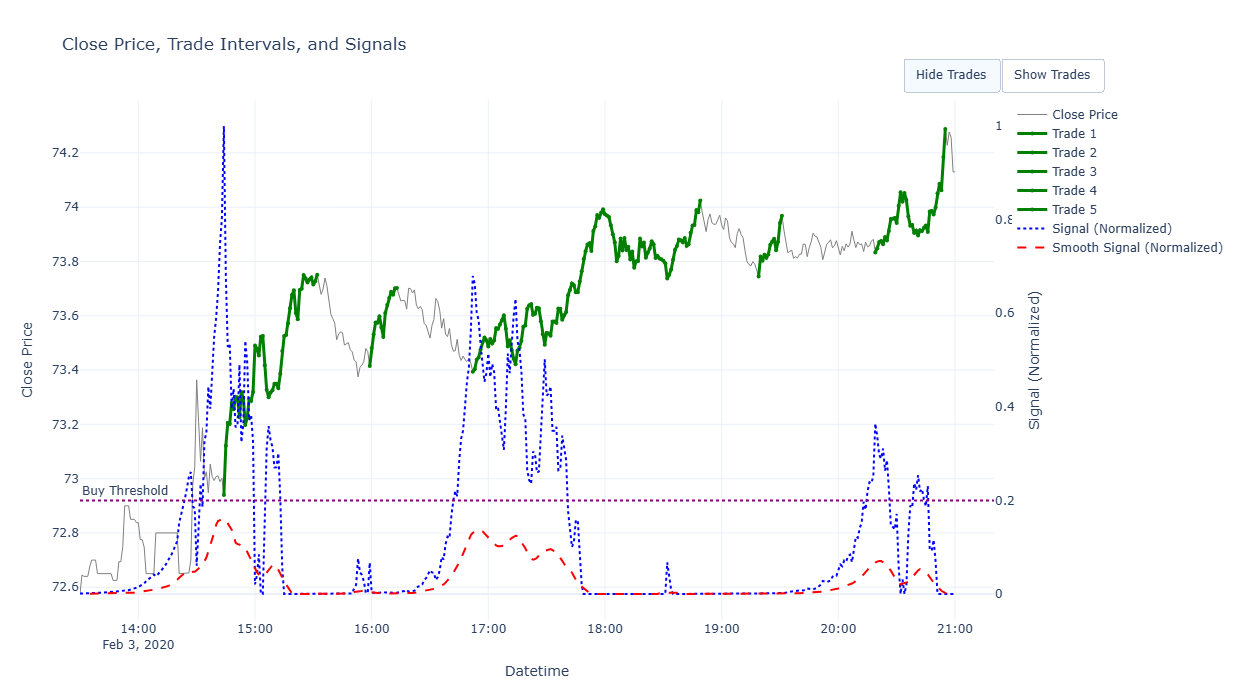

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.0),
             ('Buy & Hold Gain ($)', 0.722),
             ('Strategy Profit Difference ($)', -0.722),
             ('Final Net Return (%)', 0.0),
             ('Buy & Hold Return (%)', 0.983),
             ('Strategy Improvement (%)', -0.983),
             ('Trade Gains ($)', []),
             ('Trade Gains (%)', [])])

=== Processing trading day 2020-02-04 ===
Step 1/5 for 2020-02-04 => smooth_prepost_trading_data started at 20:16:47
Step 1/5 for 2020-02-04 => completed at 20:16:47
Step 2/5 for 2020-02-04 => identify_trades_daily started at 20:16:47
Step 2/5 for 2020-02-04 => completed at 20:16:47
Step 3/5 for 2020-02-04 => add_trade_signal_to_results started at 20:16:47
Step 3/5 for 2020-02-04 => completed at 20:16:47
Step 4/5 for 2020-02-04 => simulate_trading started at 20:16:47
Step 4/5 for 2020-02-04 => completed at 20:16:47
Step 5/5 Plotting trading results for 2020-02-04


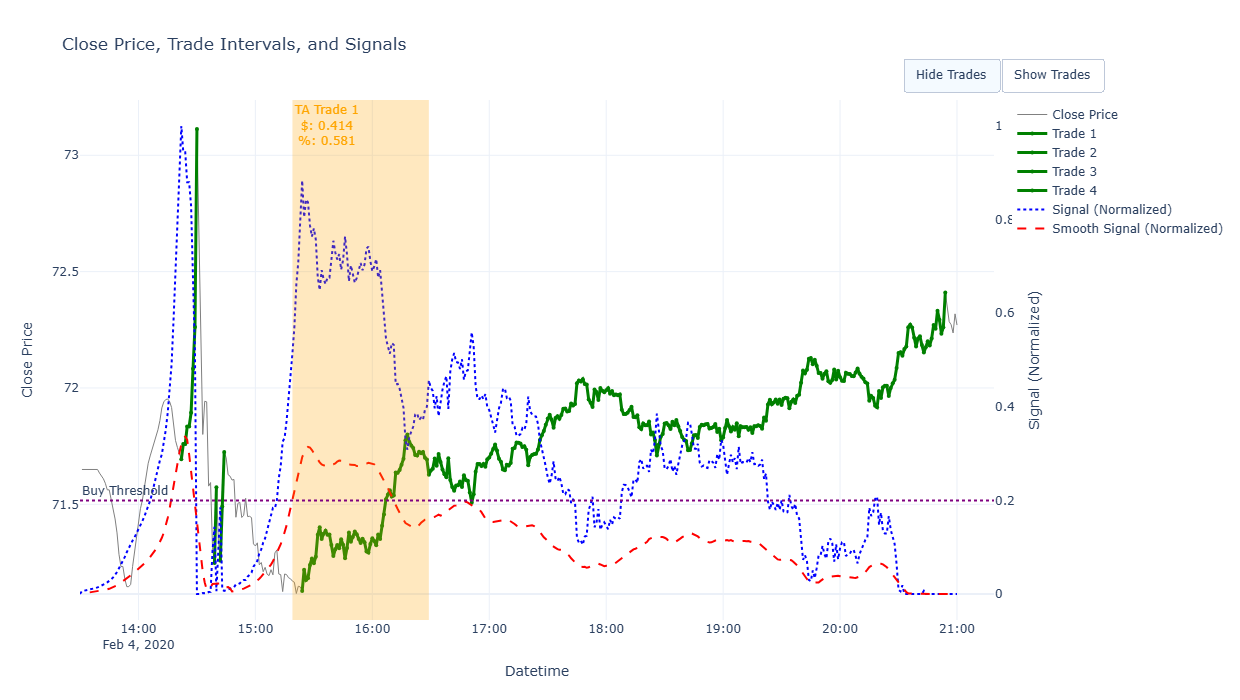

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.414),
             ('Buy & Hold Gain ($)', -0.838),
             ('Strategy Profit Difference ($)', 1.252),
             ('Final Net Return (%)', 0.566),
             ('Buy & Hold Return (%)', -1.146),
             ('Strategy Improvement (%)', 1.712),
             ('Trade Gains ($)', [0.414]),
             ('Trade Gains (%)', [0.581])])

=== Processing trading day 2020-02-05 ===
Step 1/5 for 2020-02-05 => smooth_prepost_trading_data started at 20:16:47
Step 1/5 for 2020-02-05 => completed at 20:16:47
Step 2/5 for 2020-02-05 => identify_trades_daily started at 20:16:47
Step 2/5 for 2020-02-05 => completed at 20:16:47
Step 3/5 for 2020-02-05 => add_trade_signal_to_results started at 20:16:47
Step 3/5 for 2020-02-05 => completed at 20:16:47
Step 4/5 for 2020-02-05 => simulate_trading started at 20:16:47
Step 4/5 for 2020-02-05 => completed at 20:16:47
Step 5/5 Plotting trading results for 2020-02-05


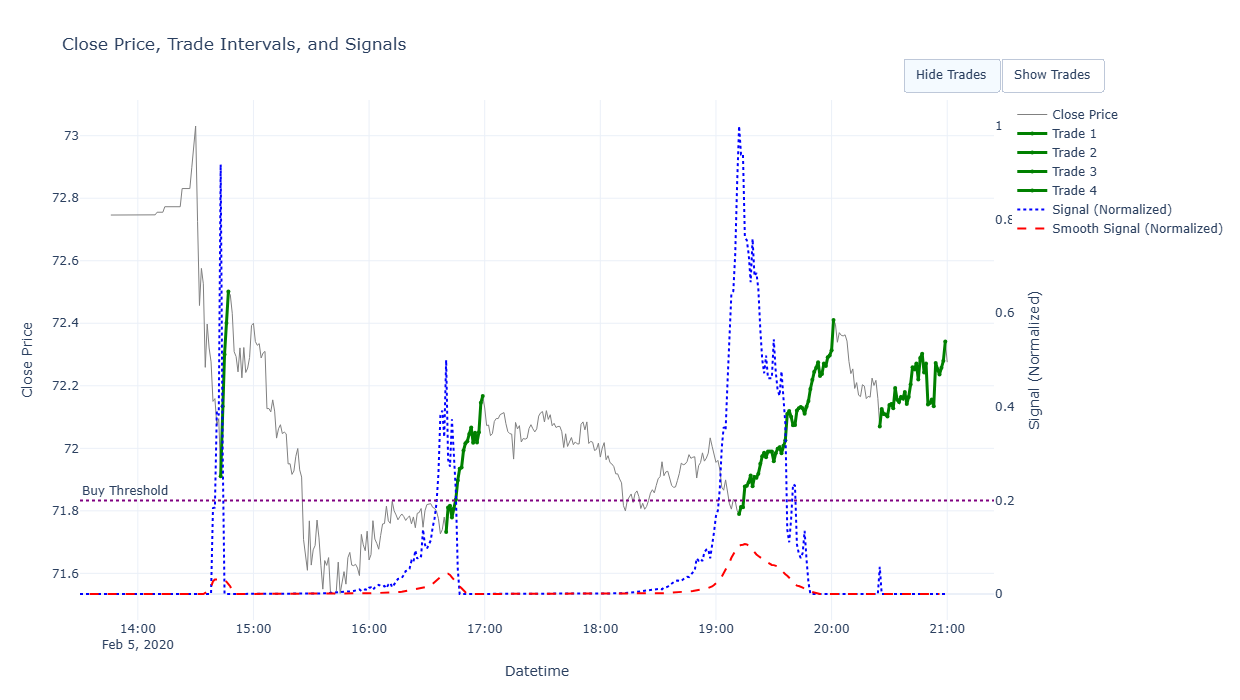

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.0),
             ('Buy & Hold Gain ($)', -0.733),
             ('Strategy Profit Difference ($)', 0.733),
             ('Final Net Return (%)', 0.0),
             ('Buy & Hold Return (%)', -1.004),
             ('Strategy Improvement (%)', 1.004),
             ('Trade Gains ($)', []),
             ('Trade Gains (%)', [])])

=== Processing trading day 2020-02-06 ===
Step 1/5 for 2020-02-06 => smooth_prepost_trading_data started at 20:16:48
Step 1/5 for 2020-02-06 => completed at 20:16:48
Step 2/5 for 2020-02-06 => identify_trades_daily started at 20:16:48
Step 2/5 for 2020-02-06 => completed at 20:16:48
Step 3/5 for 2020-02-06 => add_trade_signal_to_results started at 20:16:48
Step 3/5 for 2020-02-06 => completed at 20:16:48
Step 4/5 for 2020-02-06 => simulate_trading started at 20:16:48
Step 4/5 for 2020-02-06 => completed at 20:16:48
Step 5/5 Plotting trading results for 2020-02-06


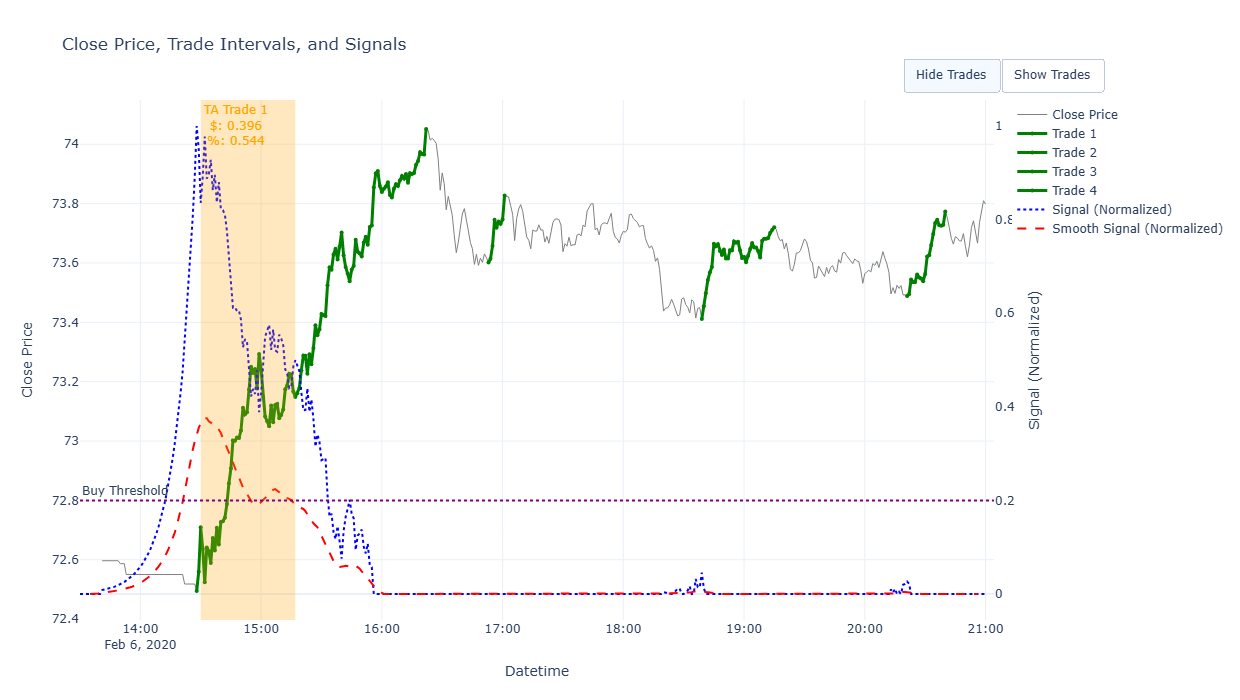

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.396),
             ('Buy & Hold Gain ($)', 1.057),
             ('Strategy Profit Difference ($)', -0.661),
             ('Final Net Return (%)', 0.544),
             ('Buy & Hold Return (%)', 1.453),
             ('Strategy Improvement (%)', -0.909),
             ('Trade Gains ($)', [0.396]),
             ('Trade Gains (%)', [0.544])])

=== Processing trading day 2020-02-07 ===
Step 1/5 for 2020-02-07 => smooth_prepost_trading_data started at 20:16:48
Step 1/5 for 2020-02-07 => completed at 20:16:48
Step 2/5 for 2020-02-07 => identify_trades_daily started at 20:16:48
Step 2/5 for 2020-02-07 => completed at 20:16:48
Step 3/5 for 2020-02-07 => add_trade_signal_to_results started at 20:16:48
Step 3/5 for 2020-02-07 => completed at 20:16:48
Step 4/5 for 2020-02-07 => simulate_trading started at 20:16:48
Step 4/5 for 2020-02-07 => completed at 20:16:48
Step 5/5 Plotting trading results for 2020-02-07


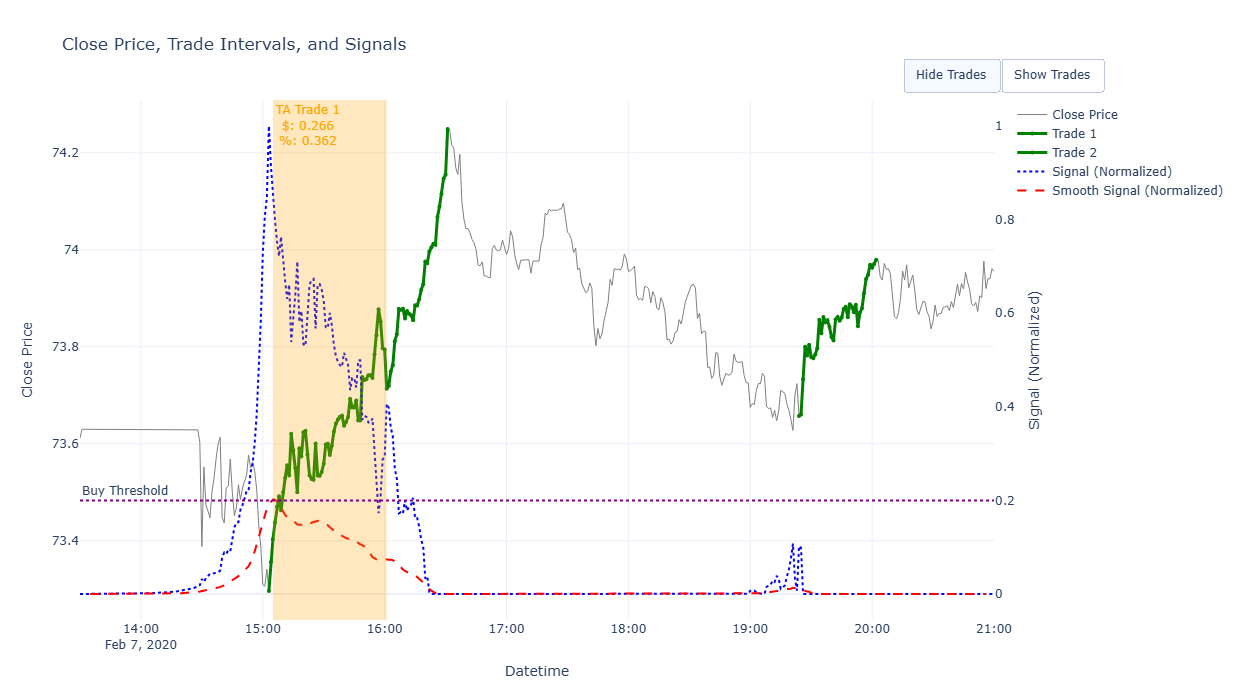

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.266),
             ('Buy & Hold Gain ($)', 0.529),
             ('Strategy Profit Difference ($)', -0.263),
             ('Final Net Return (%)', 0.362),
             ('Buy & Hold Return (%)', 0.72),
             ('Strategy Improvement (%)', -0.358),
             ('Trade Gains ($)', [0.266]),
             ('Trade Gains (%)', [0.362])])

=== Processing trading day 2020-02-08 ===
Step 1/5 for 2020-02-08 => smooth_prepost_trading_data started at 20:16:48
Step 1/5 for 2020-02-08 => completed at 20:16:48
Step 2/5 for 2020-02-08 => identify_trades_daily started at 20:16:48
Step 2/5 for 2020-02-08 => completed at 20:16:48
Step 3/5 for 2020-02-08 => add_trade_signal_to_results started at 20:16:48
Step 3/5 for 2020-02-08 => completed at 20:16:48
Step 4/5 for 2020-02-08 => simulate_trading started at 20:16:48
Step 4/5 for 2020-02-08 => completed at 20:16:48
No trading results for 2020-02-08 (maybe a weekend or holiday).

=== Processing tr

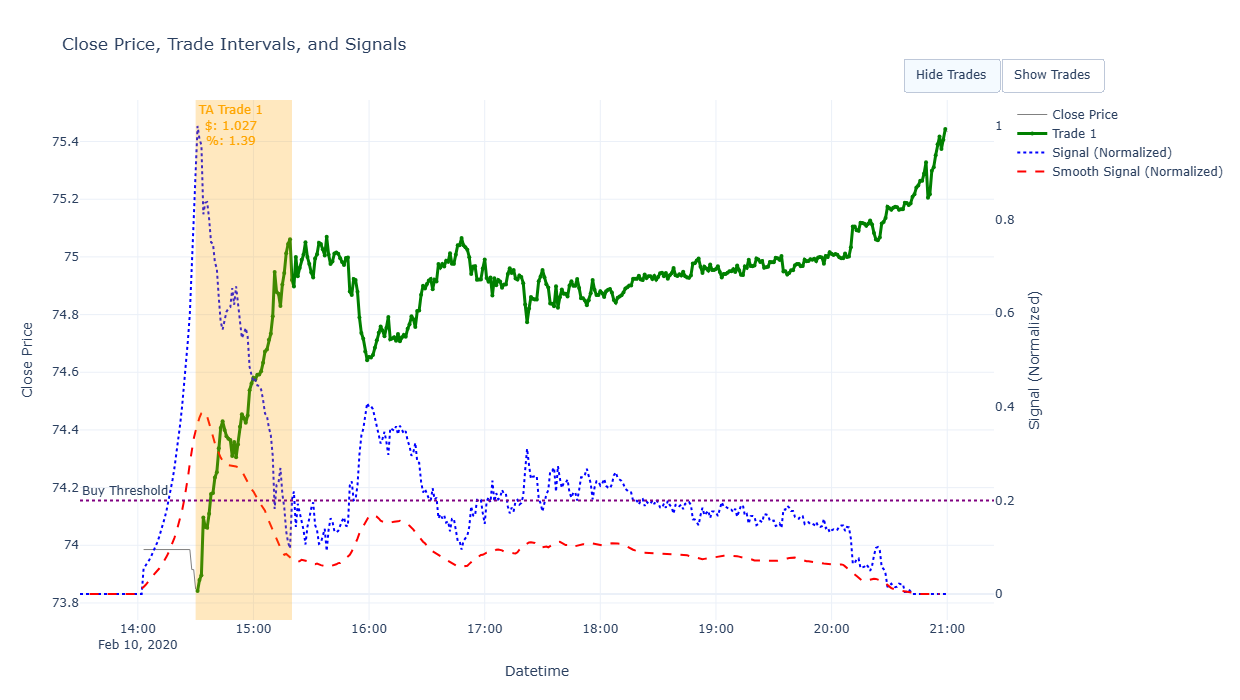

Daily Performance:
OrderedDict([('Final Net Value ($)', 1.027),
             ('Buy & Hold Gain ($)', 1.551),
             ('Strategy Profit Difference ($)', -0.524),
             ('Final Net Return (%)', 1.39),
             ('Buy & Hold Return (%)', 2.099),
             ('Strategy Improvement (%)', -0.709),
             ('Trade Gains ($)', [1.027]),
             ('Trade Gains (%)', [1.39])])

=== Processing trading day 2020-02-11 ===
Step 1/5 for 2020-02-11 => smooth_prepost_trading_data started at 20:16:48
Step 1/5 for 2020-02-11 => completed at 20:16:48
Step 2/5 for 2020-02-11 => identify_trades_daily started at 20:16:48
Step 2/5 for 2020-02-11 => completed at 20:16:48
Step 3/5 for 2020-02-11 => add_trade_signal_to_results started at 20:16:48
Step 3/5 for 2020-02-11 => completed at 20:16:49
Step 4/5 for 2020-02-11 => simulate_trading started at 20:16:49
Step 4/5 for 2020-02-11 => completed at 20:16:49
Step 5/5 Plotting trading results for 2020-02-11


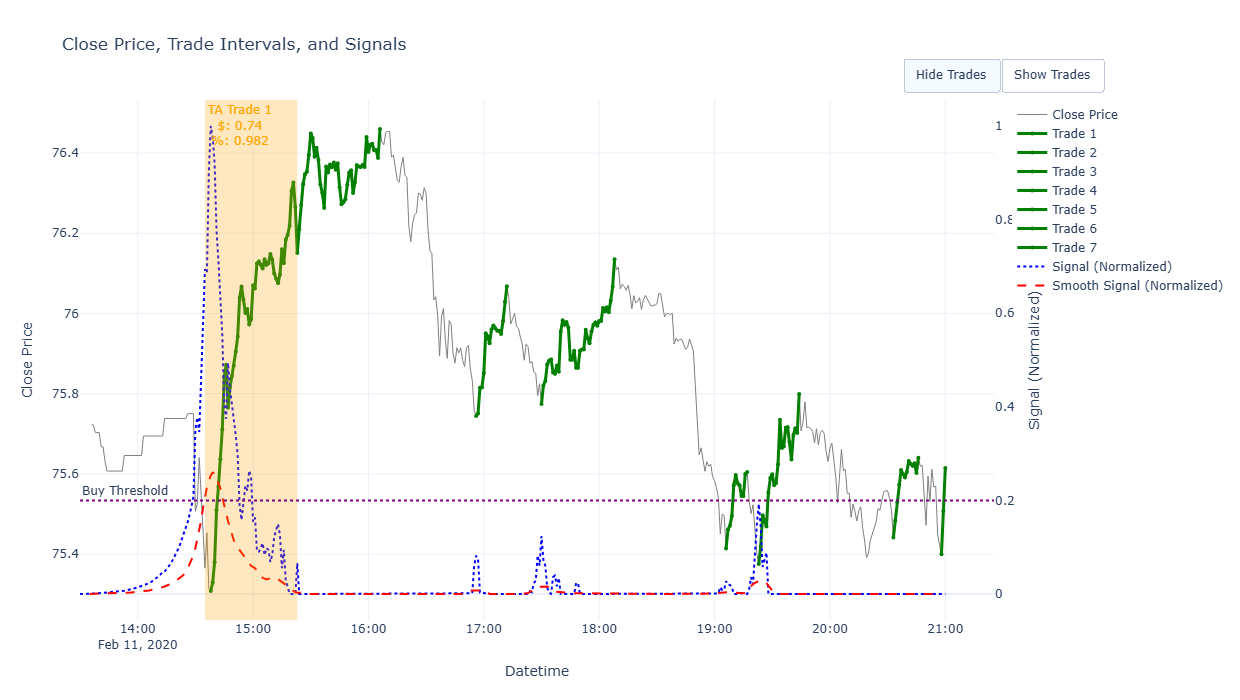

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.74),
             ('Buy & Hold Gain ($)', -0.045),
             ('Strategy Profit Difference ($)', 0.785),
             ('Final Net Return (%)', 0.98),
             ('Buy & Hold Return (%)', -0.059),
             ('Strategy Improvement (%)', 1.039),
             ('Trade Gains ($)', [0.74]),
             ('Trade Gains (%)', [0.982])])

=== Processing trading day 2020-02-12 ===
Step 1/5 for 2020-02-12 => smooth_prepost_trading_data started at 20:16:49
Step 1/5 for 2020-02-12 => completed at 20:16:49
Step 2/5 for 2020-02-12 => identify_trades_daily started at 20:16:49
Step 2/5 for 2020-02-12 => completed at 20:16:49
Step 3/5 for 2020-02-12 => add_trade_signal_to_results started at 20:16:49
Step 3/5 for 2020-02-12 => completed at 20:16:49
Step 4/5 for 2020-02-12 => simulate_trading started at 20:16:49
Step 4/5 for 2020-02-12 => completed at 20:16:49
Step 5/5 Plotting trading results for 2020-02-12


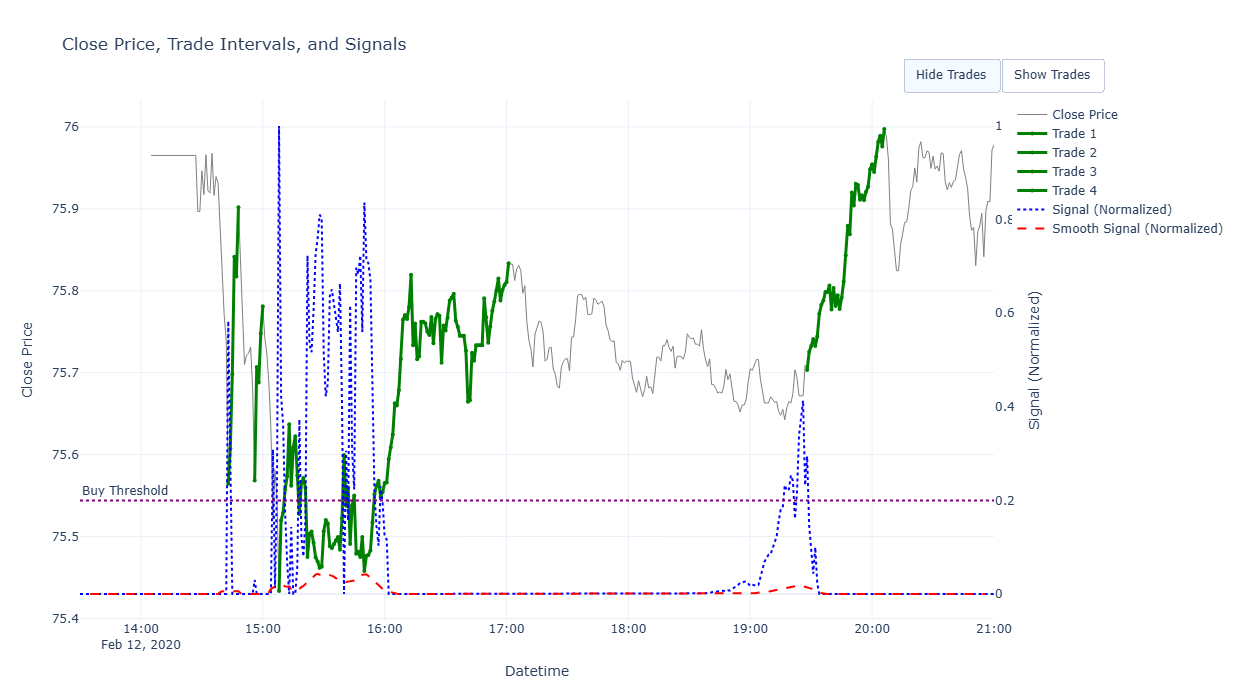

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.0),
             ('Buy & Hold Gain ($)', -0.021),
             ('Strategy Profit Difference ($)', 0.021),
             ('Final Net Return (%)', 0.0),
             ('Buy & Hold Return (%)', -0.027),
             ('Strategy Improvement (%)', 0.027),
             ('Trade Gains ($)', []),
             ('Trade Gains (%)', [])])

=== Processing trading day 2020-02-13 ===
Step 1/5 for 2020-02-13 => smooth_prepost_trading_data started at 20:16:49
Step 1/5 for 2020-02-13 => completed at 20:16:49
Step 2/5 for 2020-02-13 => identify_trades_daily started at 20:16:49
Step 2/5 for 2020-02-13 => completed at 20:16:49
Step 3/5 for 2020-02-13 => add_trade_signal_to_results started at 20:16:49
Step 3/5 for 2020-02-13 => completed at 20:16:49
Step 4/5 for 2020-02-13 => simulate_trading started at 20:16:49
Step 4/5 for 2020-02-13 => completed at 20:16:49
Step 5/5 Plotting trading results for 2020-02-13


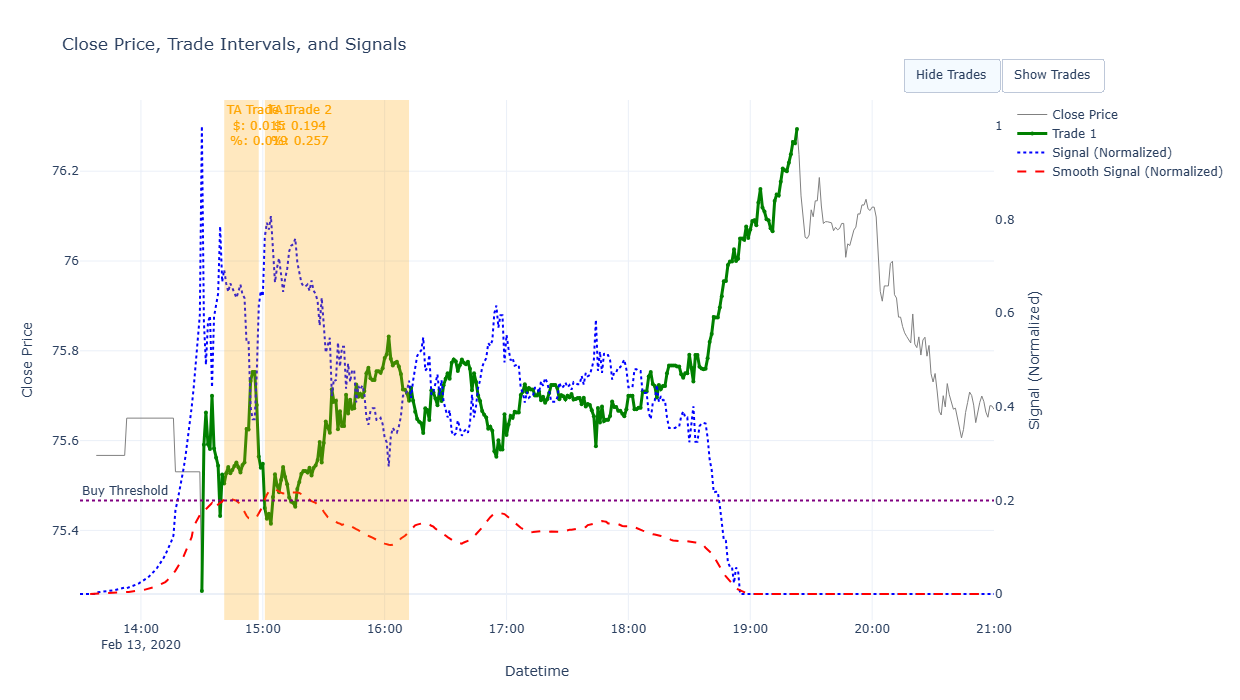

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.208),
             ('Buy & Hold Gain ($)', 0.367),
             ('Strategy Profit Difference ($)', -0.159),
             ('Final Net Return (%)', 0.276),
             ('Buy & Hold Return (%)', 0.487),
             ('Strategy Improvement (%)', -0.211),
             ('Trade Gains ($)', [0.015, 0.194]),
             ('Trade Gains (%)', [0.019, 0.257])])

=== Processing trading day 2020-02-14 ===
Step 1/5 for 2020-02-14 => smooth_prepost_trading_data started at 20:16:49
Step 1/5 for 2020-02-14 => completed at 20:16:49
Step 2/5 for 2020-02-14 => identify_trades_daily started at 20:16:49
Step 2/5 for 2020-02-14 => completed at 20:16:49
Step 3/5 for 2020-02-14 => add_trade_signal_to_results started at 20:16:49
Step 3/5 for 2020-02-14 => completed at 20:16:50
Step 4/5 for 2020-02-14 => simulate_trading started at 20:16:50
Step 4/5 for 2020-02-14 => completed at 20:16:50
Step 5/5 Plotting trading results for 2020-02-14


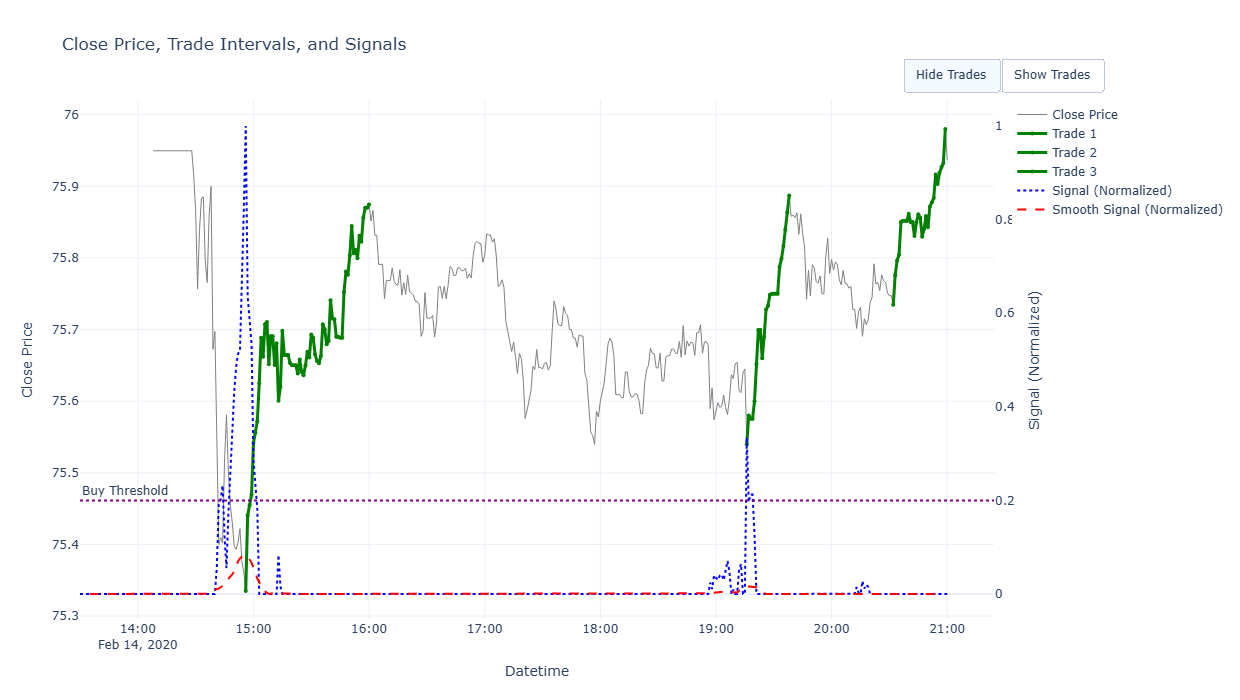

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.0),
             ('Buy & Hold Gain ($)', 0.068),
             ('Strategy Profit Difference ($)', -0.068),
             ('Final Net Return (%)', 0.0),
             ('Buy & Hold Return (%)', 0.09),
             ('Strategy Improvement (%)', -0.09),
             ('Trade Gains ($)', []),
             ('Trade Gains (%)', [])])

=== Processing trading day 2020-02-18 ===
Step 1/5 for 2020-02-18 => smooth_prepost_trading_data started at 20:16:50
Step 1/5 for 2020-02-18 => completed at 20:16:50
Step 2/5 for 2020-02-18 => identify_trades_daily started at 20:16:50
Step 2/5 for 2020-02-18 => completed at 20:16:50
Step 3/5 for 2020-02-18 => add_trade_signal_to_results started at 20:16:50
Step 3/5 for 2020-02-18 => completed at 20:16:50
Step 4/5 for 2020-02-18 => simulate_trading started at 20:16:50
Step 4/5 for 2020-02-18 => completed at 20:16:50
Step 5/5 Plotting trading results for 2020-02-18


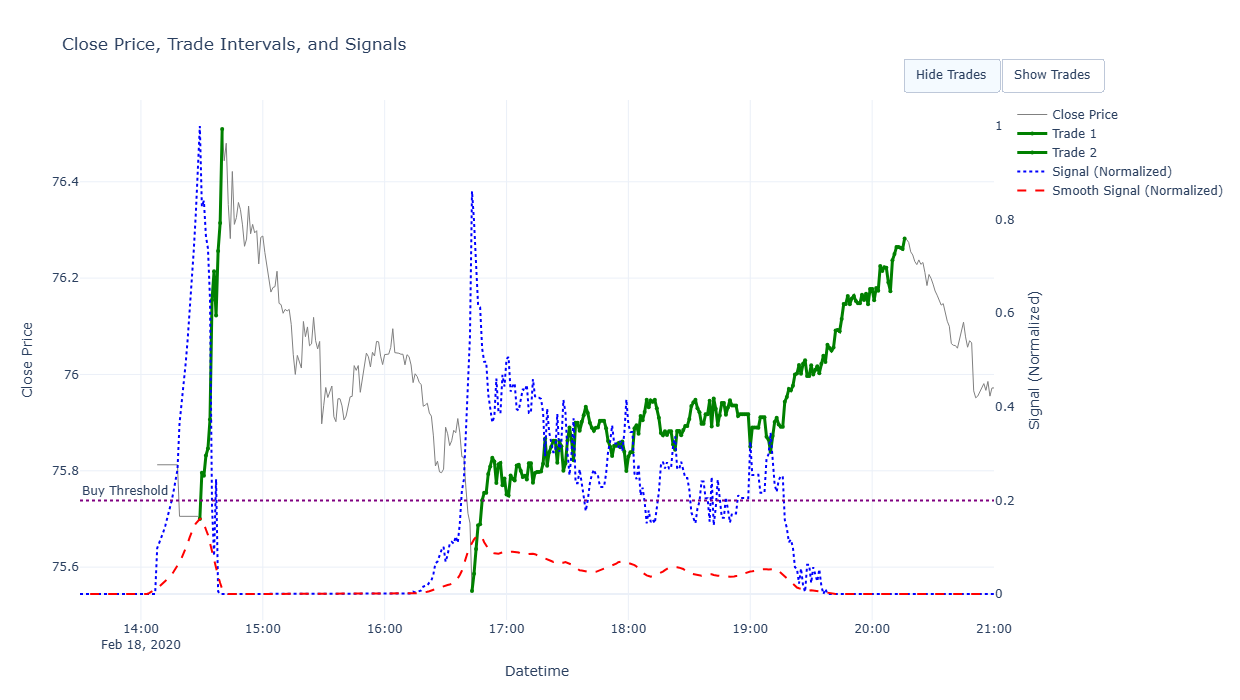

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.0),
             ('Buy & Hold Gain ($)', 0.13),
             ('Strategy Profit Difference ($)', -0.13),
             ('Final Net Return (%)', 0.0),
             ('Buy & Hold Return (%)', 0.172),
             ('Strategy Improvement (%)', -0.172),
             ('Trade Gains ($)', []),
             ('Trade Gains (%)', [])])

=== Processing trading day 2020-02-19 ===
Step 1/5 for 2020-02-19 => smooth_prepost_trading_data started at 20:16:50
Step 1/5 for 2020-02-19 => completed at 20:16:50
Step 2/5 for 2020-02-19 => identify_trades_daily started at 20:16:50
Step 2/5 for 2020-02-19 => completed at 20:16:50
Step 3/5 for 2020-02-19 => add_trade_signal_to_results started at 20:16:50
Step 3/5 for 2020-02-19 => completed at 20:16:50
Step 4/5 for 2020-02-19 => simulate_trading started at 20:16:50
Step 4/5 for 2020-02-19 => completed at 20:16:50
Step 5/5 Plotting trading results for 2020-02-19


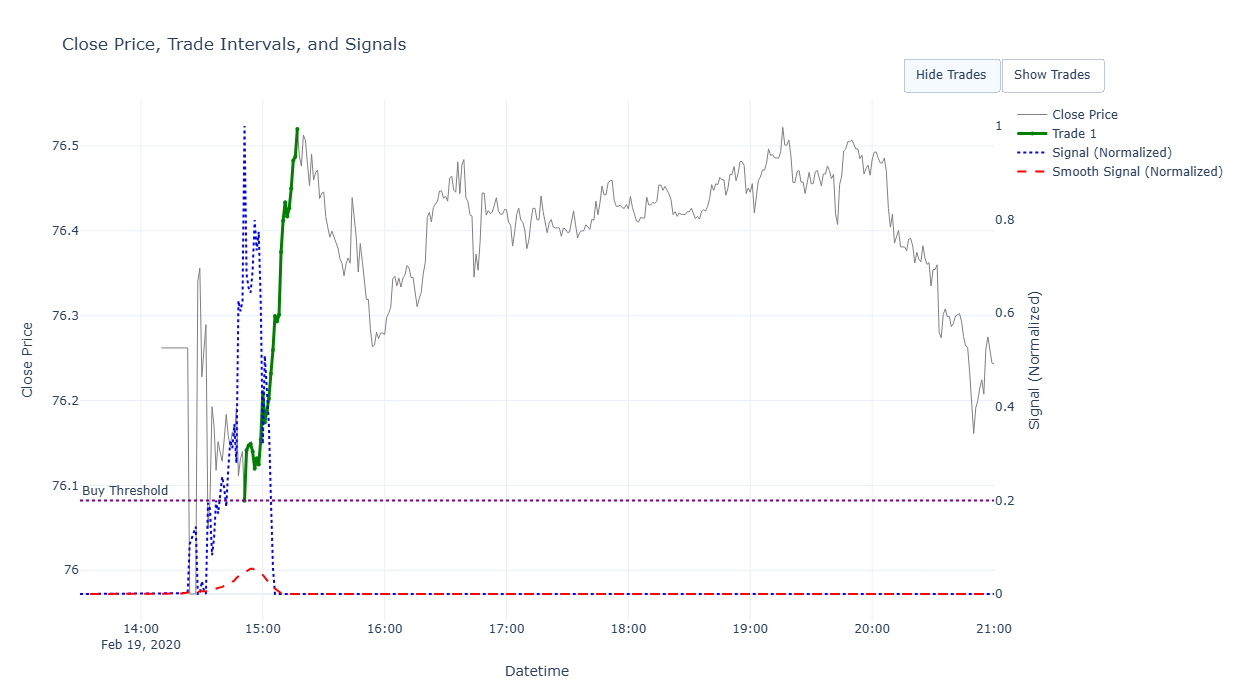

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.0),
             ('Buy & Hold Gain ($)', -0.03),
             ('Strategy Profit Difference ($)', 0.03),
             ('Final Net Return (%)', 0.0),
             ('Buy & Hold Return (%)', -0.039),
             ('Strategy Improvement (%)', 0.039),
             ('Trade Gains ($)', []),
             ('Trade Gains (%)', [])])

=== Processing trading day 2020-02-20 ===
Step 1/5 for 2020-02-20 => smooth_prepost_trading_data started at 20:16:50
Step 1/5 for 2020-02-20 => completed at 20:16:50
Step 2/5 for 2020-02-20 => identify_trades_daily started at 20:16:50
Step 2/5 for 2020-02-20 => completed at 20:16:50
Step 3/5 for 2020-02-20 => add_trade_signal_to_results started at 20:16:50
Step 3/5 for 2020-02-20 => completed at 20:16:50
Step 4/5 for 2020-02-20 => simulate_trading started at 20:16:50
Step 4/5 for 2020-02-20 => completed at 20:16:51
Step 5/5 Plotting trading results for 2020-02-20


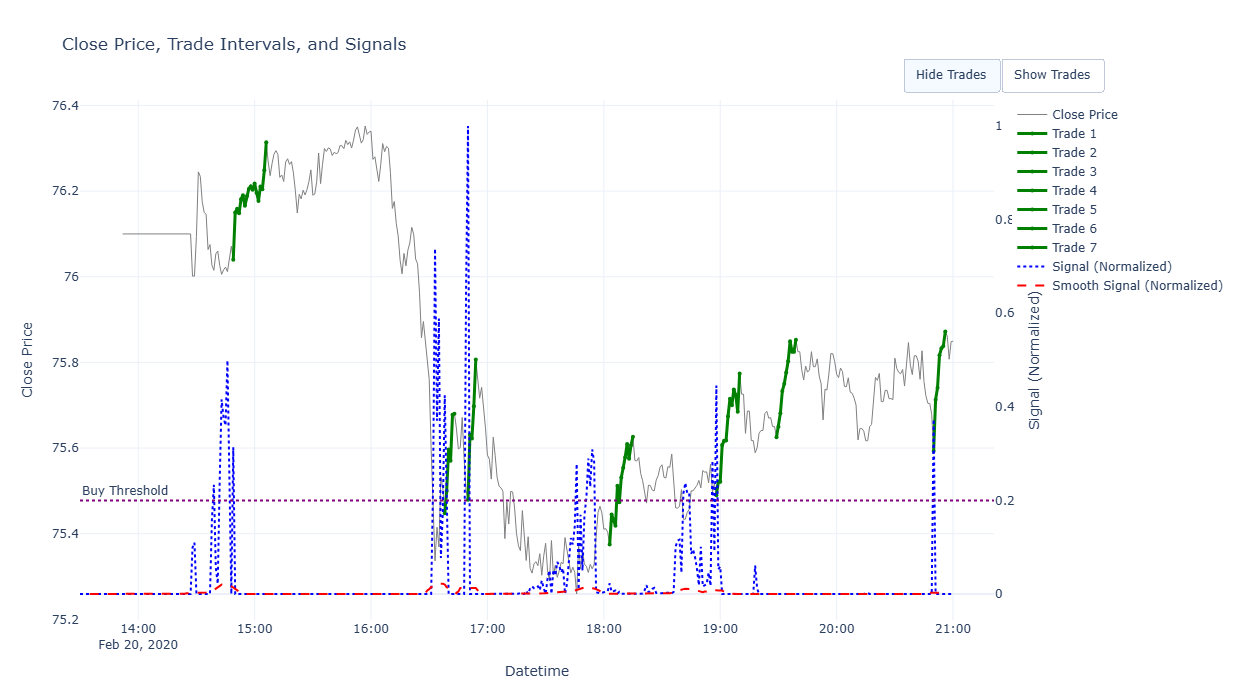

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.0),
             ('Buy & Hold Gain ($)', -0.291),
             ('Strategy Profit Difference ($)', 0.291),
             ('Final Net Return (%)', 0.0),
             ('Buy & Hold Return (%)', -0.382),
             ('Strategy Improvement (%)', 0.382),
             ('Trade Gains ($)', []),
             ('Trade Gains (%)', [])])

=== Processing trading day 2020-02-21 ===
Step 1/5 for 2020-02-21 => smooth_prepost_trading_data started at 20:16:51
Step 1/5 for 2020-02-21 => completed at 20:16:51
Step 2/5 for 2020-02-21 => identify_trades_daily started at 20:16:51
Step 2/5 for 2020-02-21 => completed at 20:16:51
Step 3/5 for 2020-02-21 => add_trade_signal_to_results started at 20:16:51
Step 3/5 for 2020-02-21 => completed at 20:16:51
Step 4/5 for 2020-02-21 => simulate_trading started at 20:16:51
Step 4/5 for 2020-02-21 => completed at 20:16:51
Step 5/5 Plotting trading results for 2020-02-21


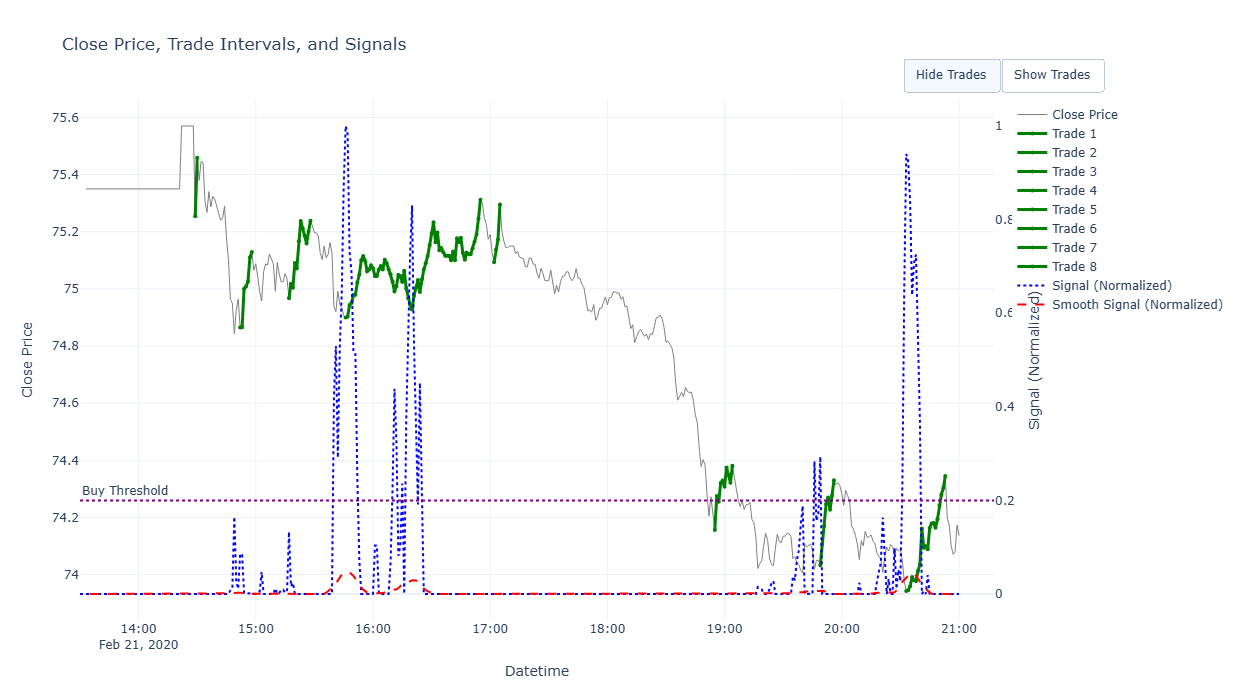

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.0),
             ('Buy & Hold Gain ($)', -1.33),
             ('Strategy Profit Difference ($)', 1.33),
             ('Final Net Return (%)', 0.0),
             ('Buy & Hold Return (%)', -1.762),
             ('Strategy Improvement (%)', 1.762),
             ('Trade Gains ($)', []),
             ('Trade Gains (%)', [])])

=== Processing trading day 2020-02-22 ===
Step 1/5 for 2020-02-22 => smooth_prepost_trading_data started at 20:16:51
Step 1/5 for 2020-02-22 => completed at 20:16:51
Step 2/5 for 2020-02-22 => identify_trades_daily started at 20:16:51
Step 2/5 for 2020-02-22 => completed at 20:16:51
Step 3/5 for 2020-02-22 => add_trade_signal_to_results started at 20:16:51
Step 3/5 for 2020-02-22 => completed at 20:16:51
Step 4/5 for 2020-02-22 => simulate_trading started at 20:16:51
Step 4/5 for 2020-02-22 => completed at 20:16:51
No trading results for 2020-02-22 (maybe a weekend or holiday).

=== Processing trading day 2020-

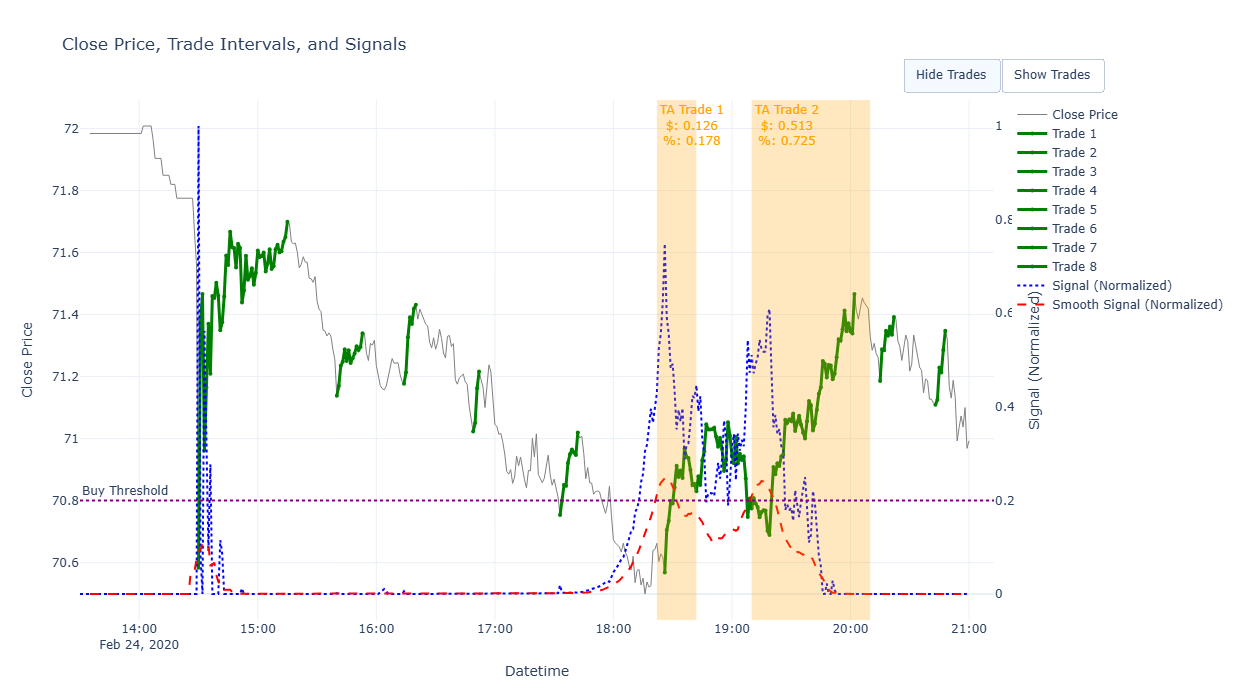

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.639),
             ('Buy & Hold Gain ($)', 0.343),
             ('Strategy Profit Difference ($)', 0.296),
             ('Final Net Return (%)', 0.905),
             ('Buy & Hold Return (%)', 0.485),
             ('Strategy Improvement (%)', 0.42),
             ('Trade Gains ($)', [0.126, 0.513]),
             ('Trade Gains (%)', [0.178, 0.725])])

=== Processing trading day 2020-02-25 ===
Step 1/5 for 2020-02-25 => smooth_prepost_trading_data started at 20:16:51
Step 1/5 for 2020-02-25 => completed at 20:16:51
Step 2/5 for 2020-02-25 => identify_trades_daily started at 20:16:51
Step 2/5 for 2020-02-25 => completed at 20:16:51
Step 3/5 for 2020-02-25 => add_trade_signal_to_results started at 20:16:51
Step 3/5 for 2020-02-25 => completed at 20:16:52
Step 4/5 for 2020-02-25 => simulate_trading started at 20:16:52
Step 4/5 for 2020-02-25 => completed at 20:16:52
Step 5/5 Plotting trading results for 2020-02-25


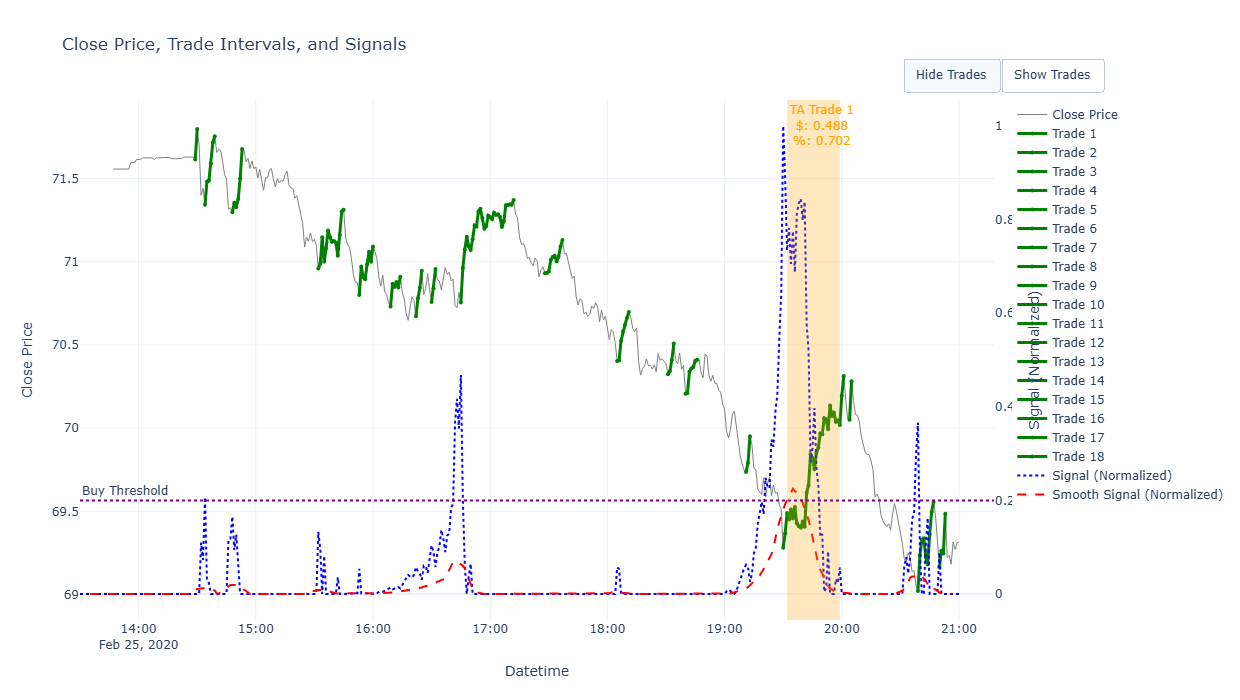

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.488),
             ('Buy & Hold Gain ($)', -2.529),
             ('Strategy Profit Difference ($)', 3.017),
             ('Final Net Return (%)', 0.679),
             ('Buy & Hold Return (%)', -3.522),
             ('Strategy Improvement (%)', 4.201),
             ('Trade Gains ($)', [0.488]),
             ('Trade Gains (%)', [0.702])])

=== Processing trading day 2020-02-26 ===
Step 1/5 for 2020-02-26 => smooth_prepost_trading_data started at 20:16:52
Step 1/5 for 2020-02-26 => completed at 20:16:52
Step 2/5 for 2020-02-26 => identify_trades_daily started at 20:16:52
Step 2/5 for 2020-02-26 => completed at 20:16:52
Step 3/5 for 2020-02-26 => add_trade_signal_to_results started at 20:16:52
Step 3/5 for 2020-02-26 => completed at 20:16:52
Step 4/5 for 2020-02-26 => simulate_trading started at 20:16:52
Step 4/5 for 2020-02-26 => completed at 20:16:52
Step 5/5 Plotting trading results for 2020-02-26


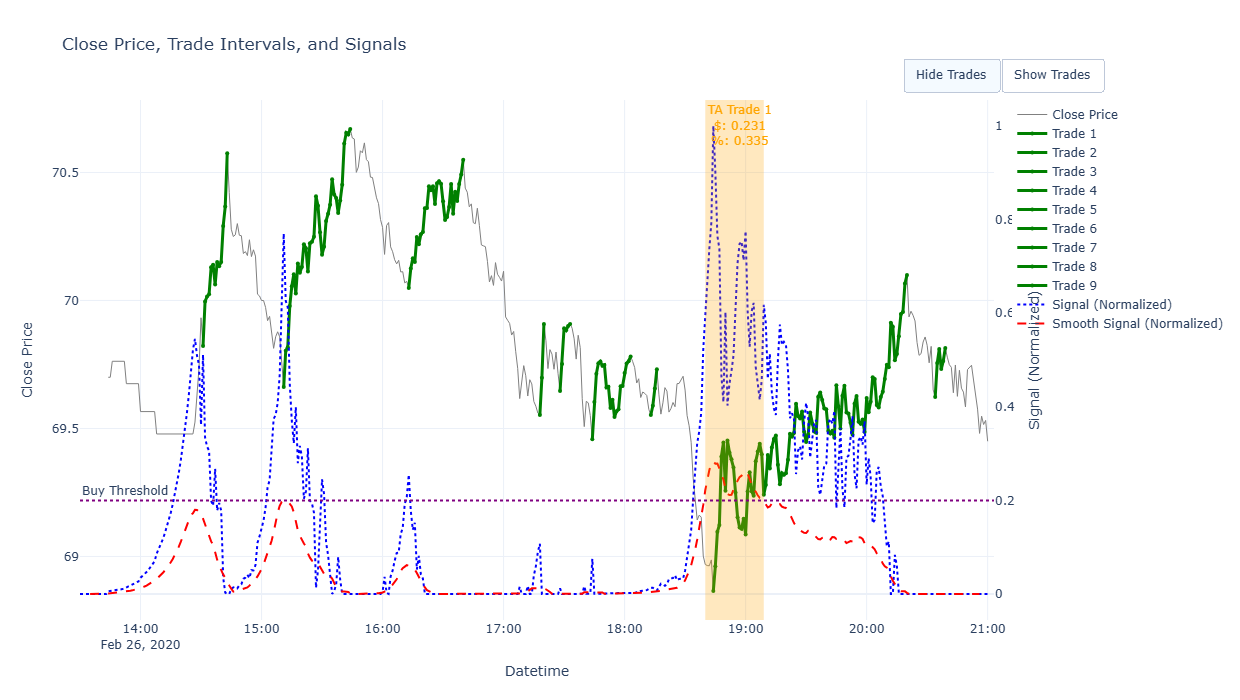

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.231),
             ('Buy & Hold Gain ($)', -0.443),
             ('Strategy Profit Difference ($)', 0.674),
             ('Final Net Return (%)', 0.33),
             ('Buy & Hold Return (%)', -0.633),
             ('Strategy Improvement (%)', 0.963),
             ('Trade Gains ($)', [0.231]),
             ('Trade Gains (%)', [0.335])])

=== Processing trading day 2020-02-27 ===
Step 1/5 for 2020-02-27 => smooth_prepost_trading_data started at 20:16:53
Step 1/5 for 2020-02-27 => completed at 20:16:53
Step 2/5 for 2020-02-27 => identify_trades_daily started at 20:16:53
Step 2/5 for 2020-02-27 => completed at 20:16:53
Step 3/5 for 2020-02-27 => add_trade_signal_to_results started at 20:16:53
Step 3/5 for 2020-02-27 => completed at 20:16:53
Step 4/5 for 2020-02-27 => simulate_trading started at 20:16:53
Step 4/5 for 2020-02-27 => completed at 20:16:53
Step 5/5 Plotting trading results for 2020-02-27


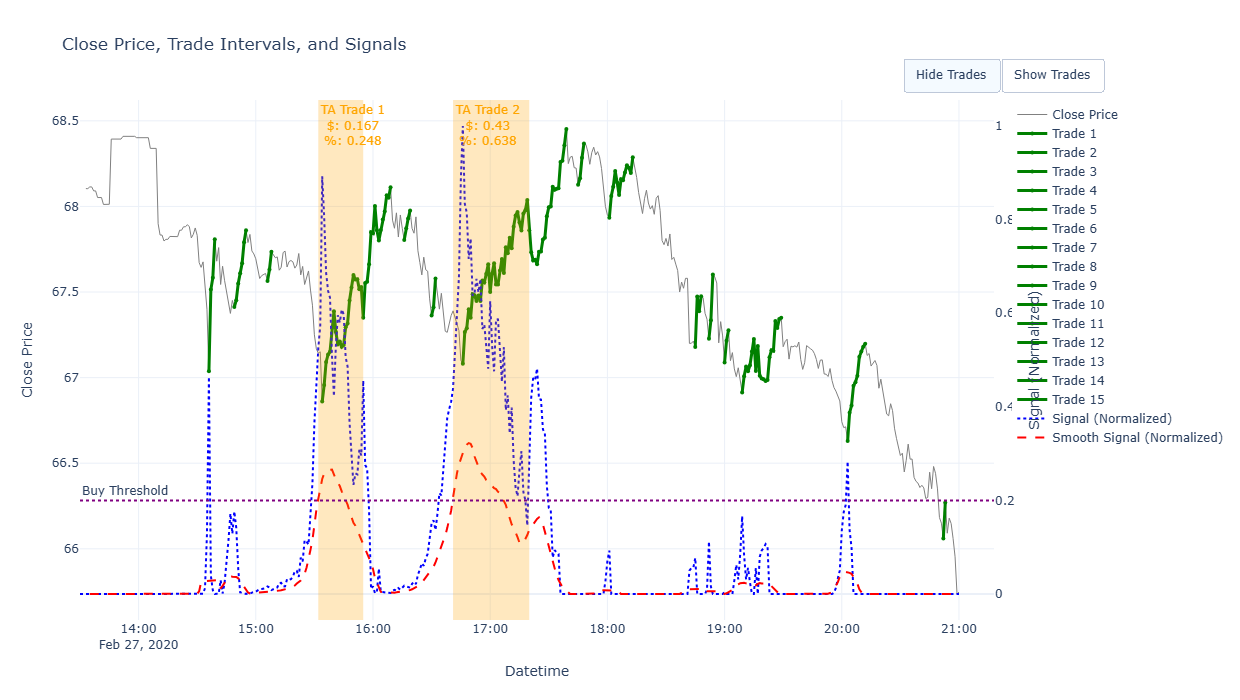

Daily Performance:
OrderedDict([('Final Net Value ($)', 0.597),
             ('Buy & Hold Gain ($)', -2.135),
             ('Strategy Profit Difference ($)', 2.732),
             ('Final Net Return (%)', 0.88),
             ('Buy & Hold Return (%)', -3.147),
             ('Strategy Improvement (%)', 4.027),
             ('Trade Gains ($)', [0.167, 0.43]),
             ('Trade Gains (%)', [0.248, 0.638])])

=== Processing trading day 2020-02-28 ===
Step 1/5 for 2020-02-28 => smooth_prepost_trading_data started at 20:16:53
Step 1/5 for 2020-02-28 => completed at 20:16:53
Step 2/5 for 2020-02-28 => identify_trades_daily started at 20:16:53
Step 2/5 for 2020-02-28 => completed at 20:16:53
Step 3/5 for 2020-02-28 => add_trade_signal_to_results started at 20:16:53
Step 3/5 for 2020-02-28 => completed at 20:16:53
Step 4/5 for 2020-02-28 => simulate_trading started at 20:16:53
Step 4/5 for 2020-02-28 => completed at 20:16:53
Step 5/5 Plotting trading results for 2020-02-28


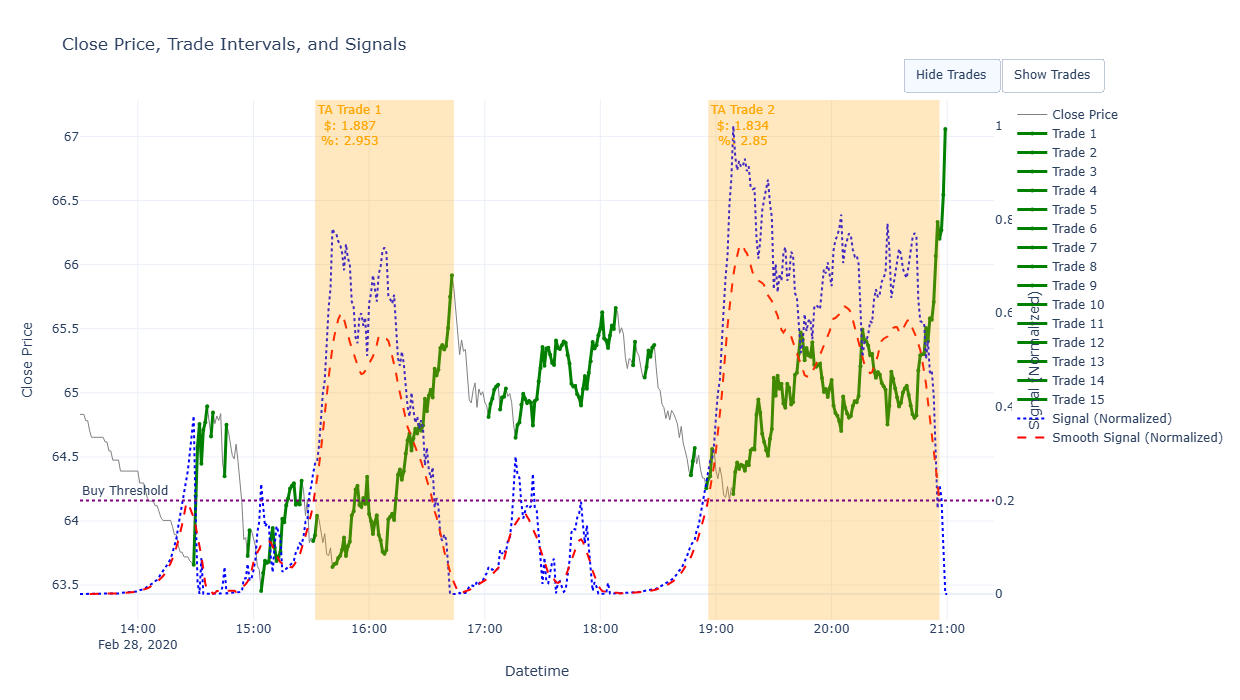

Daily Performance:
OrderedDict([('Final Net Value ($)', 3.721),
             ('Buy & Hold Gain ($)', 2.822),
             ('Strategy Profit Difference ($)', 0.899),
             ('Final Net Return (%)', 5.794),
             ('Buy & Hold Return (%)', 4.394),
             ('Strategy Improvement (%)', 1.401),
             ('Trade Gains ($)', [1.887, 1.834]),
             ('Trade Gains (%)', [2.953, 2.85])])

=== Processing trading day 2020-02-29 ===
Step 1/5 for 2020-02-29 => smooth_prepost_trading_data started at 20:16:54
Step 1/5 for 2020-02-29 => completed at 20:16:54
Step 2/5 for 2020-02-29 => identify_trades_daily started at 20:16:54
Step 2/5 for 2020-02-29 => completed at 20:16:54
Step 3/5 for 2020-02-29 => add_trade_signal_to_results started at 20:16:54
Step 3/5 for 2020-02-29 => completed at 20:16:54
Step 4/5 for 2020-02-29 => simulate_trading started at 20:16:54
Step 4/5 for 2020-02-29 => completed at 20:16:54
No trading results for 2020-02-29 (maybe a weekend or holiday).

Final

In [9]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=ticker,
                        min_prof_thr=min_prof_thr, 
                        max_down_prop=max_down_prop, 
                        gain_tightening_factor=gain_tightening_factor,
                        smooth_win_sig=smooth_win_sig, 
                        pre_entry_decay=pre_entry_decay, 
                        buy_threshold=buy_threshold, 
                        trailing_stop_thresh=trailing_stop_thresh,
                        merging_retracement_thr=merging_retracement_thr, 
                        merging_time_gap_thr=merging_time_gap_thr,
                        reference_gain=reference_gain,
                        date_to_check=date_to_check
                        )

df_fin